In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

import yfinance as yf

In [2]:
import sys
sys.path.append('../') # go to parent dir
sys.path.append('/home/artem/git/sdafe')

In [3]:
from sdafe.plot import plot_qq_norm, plot_qq_t
from sdafe.ch19.risk import VaR, ES, VaR_norm, ES_norm, VaR_t, ES_t
from sdafe.ch19.tail_index import hill_curve

#### Exercise 1

In [4]:
data = pd.read_csv('../data/bmwRet.csv', index_col=0, parse_dates=[0])
data.head()

,BMW.RET
X.Y..m..d,
1973-01-02,0.047704
1973-01-03,0.007127
1973-01-04,0.008883
1973-01-05,-0.012441
1973-01-08,-0.003570


In [5]:
ret = data['BMW.RET']

(a) The non-parametric estimate of VaR(0.01) is:

In [6]:
alpha = 0.01
S = 1000

In [7]:
VaR(ret, alpha, S)

40.7975671

The non-parametric estimate of ES(0.01) is:

In [8]:
ES(ret, alpha, S)

56.49151364516129

(b)

In [9]:
mu = np.mean(ret)
sigma = np.std(ret, ddof=1)

The estimate of VaR(0.01) assuming the normal distribution:

In [10]:
VaR_norm(mu, sigma, alpha, S)

33.98576884637943

The estimate of ES(0.01) assuming the normal distribution:

In [11]:
ES_norm(mu, sigma, alpha, S)

38.98592000945358

(c)

In [12]:
fit = stats.t.fit(ret)
fit

(2.987509723919021, 0.0001323283188838053, 0.009264924408060928)

The estimate of VaR(0.01) assuming t-distribution:

In [13]:
VaR_t(*fit, alpha, S)

42.07789576763188

The estimate of ES assuming t-distribution:

In [14]:
ES_t(*fit, alpha, S)

65.09008646540109

(d) The QQ-plot against the normal quantiles shows clear evidence of fat tails, but the tails appear lighted than the fitted t-distribution:

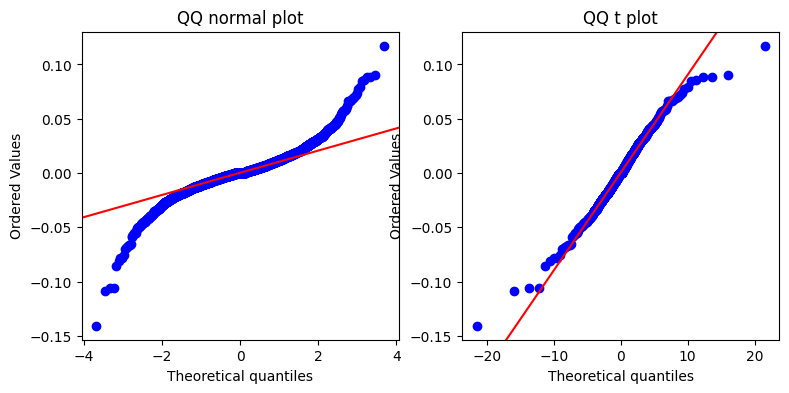

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

plot_qq_norm(axs[0], ret);
axs[0].set_title('QQ normal plot');

plot_qq_t(axs[1], ret, df=fit[0]);
axs[1].set_title('QQ t plot');

Given a fairly large sample, the non-parametric are the best choice.

#### Exercise 2

Using Eq. (19.20):

In [16]:
def VaR_poly(VaR0, alpha0, alpha, a):
    return VaR0 * (alpha0 / alpha) ** (1 / a)

In [17]:
VaR_poly(252, 0.05, 0.005, 3.1)

529.6404988557871

#### Exercise 3

In [18]:
prices = yf.download('TSLA', start='2019-01-01', end='2023-12-31')
prices

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500
...,...,...,...,...,...,...
2023-04-27,152.639999,160.479996,152.369995,160.190002,160.190002,127015200
2023-04-28,160.899994,165.000000,157.320007,164.309998,164.309998,122515800
2023-05-01,163.169998,163.279999,158.830002,161.830002,161.830002,109015000


In [19]:
ret = prices['Adj Close'].pct_change().dropna()[-1000:]

In [20]:
fit = stats.t.fit(ret)
fit

(3.2613353554202096, 0.0027252524885666143, 0.0290284892720458)

(a) The VaR(0.025) estimate is:

In [21]:
VaR_t(*fit, 0.025, 1000)

85.60648526723091

(b) The non-parametric estimate is:

In [22]:
VaR(ret, 0.025, 1000)

81.03122649986364

(c) t-distribution provides a reasonable fit to the data:

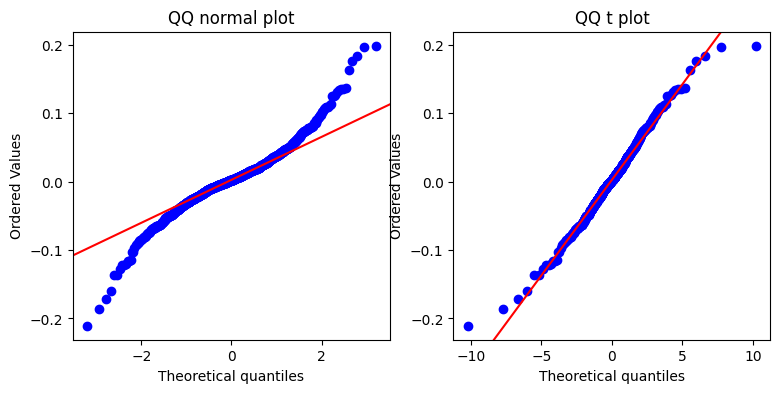

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

plot_qq_norm(axs[0], ret);
axs[0].set_title('QQ normal plot');

plot_qq_t(axs[1], ret, df=fit[0]);
axs[1].set_title('QQ t plot');

(d) We estimate the tail index using the Hill plot:

In [24]:
def unzip(x: np.array):
    return x[:, 0], x[:, 1]

In [25]:
c, nc, a = hill_curve(ret)

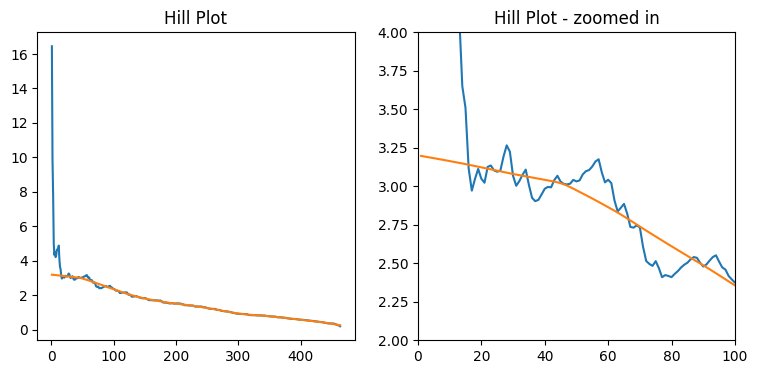

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(nc, a);
axs[0].plot(*unzip(lowess(a, nc, frac=0.1)));
axs[0].set_title('Hill Plot');

axs[1].plot(nc, a);
axs[1].plot(*unzip(lowess(a, nc, frac=0.1)));
axs[1].set_title('Hill Plot - zoomed in');
axs[1].set_xlim([0, 100]);
axs[1].set_ylim([2, 4]);

We can use 3 as the estimate for $a$, therefore the estimate of VaR(0.0025) is:

In [27]:
VaR_poly(VaR_t(*fit, 0.025, 1000), 0.025, 0.0025, 3)

184.43358155142565

#### Exercise 4

In [28]:
data = pd.read_csv('../data/msft.csv', index_col=0, parse_dates=[0])
data.head()

,Open,High,Low,Close,Volume
X.Y..m..d,,,,,
2000-09-27,63.4375,63.5625,59.8125,60.6250,53077800
2000-09-28,60.8125,61.8750,60.6250,61.3125,26180200
2000-09-29,61.0000,61.3125,58.6250,60.3125,37026800
2000-10-02,60.5000,60.8125,58.2500,59.1250,29281200
2000-10-03,59.5625,59.8125,56.5000,56.5625,42687000


In [29]:
ret = data['Close'].pct_change().dropna()

In [30]:
alpha = 0.005
S = 1000

In [31]:
fit = stats.t.fit(ret)
fit

(3.8917896357429482, -0.0015546971880293294, 0.024432875168114675)

The estimate of VaR(0.005) is:

In [32]:
VaR_est = VaR_t(*fit, alpha, S)
VaR_est

116.21070941938575

The estimate of ES(0.005) is:

In [33]:
ES_est = ES_t(*fit, alpha, S)
ES_est

160.3279770460806

In [35]:
def boot_VaR(n_boot, ret, alpha, S, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    VaRs = np.zeros(n_boot)
    ESs = np.zeros(n_boot)

    for i in range(n_boot):
        sample = ret.sample(frac=1, axis=0, replace=True, random_state=rng)
        fit = stats.t.fit(sample)
        VaRs[i] = VaR_t(*fit, alpha, S)
        ESs[i] = ES_t(*fit, alpha, S)

    return VaRs, ESs

In [36]:
n_boot = 1000

In [37]:
rng = np.random.default_rng(12345)
VaRs, ESs = boot_VaR(n_boot, ret, alpha, S, rng=rng)

The confidence interval for VaR(0.005) is:

In [38]:
alpha_boot = 0.05

In [39]:
2 * VaR_est - np.quantile(VaRs, [(1 + alpha_boot) / 2, (1 - alpha_boot) / 2])

array([117.21280036, 119.06828878])

The confidence interval for ES(0.005) is:

In [40]:
2 * ES_est - np.quantile(ESs, [(1 + alpha_boot) / 2, (1 - alpha_boot) / 2])

array([163.10558508, 166.96114998])

#### Exercise 5

Let $w = \frac{S_1}{S_1 + S_2}$, then the expected return of the portfolio with a position of size $S_1$ in the first asset and $S_2$ in the second asset is
$$w \mu_1 + (1-w) \mu_2$$
and the variance of the portfolio is
$$w^2 \sigma_1^2 + 2w (1-w) \rho \sigma_1 \sigma_2 + (1-w)^2 \sigma_2^2.$$
Therefore
$$\mathfrak{R}(P_1 + P_2) = -(S_1 + S_2)\left(w \mu_1 + (1-w) \mu_2 + \sqrt{w^2 \sigma_1^2 + 2w (1-w) \rho \sigma_1 \sigma_2 + (1-w)^2 \sigma_2^2} \Phi^{-1}(\alpha)\right).$$
On the other hand, the VaR of $P_1$ alone is
$$\mathfrak{R}(P_1) = -S_1 ( \mu_1 + \sigma_1 \Phi^{-1}(\alpha)) = -(S_1 + S_2) w ( \mu_1 + \sigma_1 \Phi^{-1}(\alpha))$$
and the VaR of $P_2$ alone is
$$\mathfrak{R}(P_2) = -S_2 ( \mu_2 + \sigma_2 \Phi^{-1}(\alpha)) = -(S_1 + S_2) (1 - w) ( \mu_2 + \sigma_2 \Phi^{-1}(\alpha))$$
hence
$$\mathfrak{R}(P_1) + \mathfrak{R}(P_2) = -(S_1 + S_2)\left(w \mu_1 + (1-w) \mu_2 + (w \sigma_1 + (1-w) \sigma_2) \Phi^{-1}(\alpha)\right).$$

Then
$$\mathfrak{R}(P_1 + P_2) - \mathfrak{R}(P_1) - \mathfrak{R}(P_2) = \Phi^{-1}(\alpha)\left( -\sqrt{w^2 \sigma_1^2 + 2w (1-w) \rho \sigma_1 \sigma_2 + (1-w)^2 \sigma_2^2} + (w \sigma_1 + (1-w) \sigma_2) \right).$$

Denote 
$$A = \sqrt{w^2 \sigma_1^2 + 2w (1-w) \rho \sigma_1 \sigma_2 + (1-w)^2 \sigma_2^2}$$
and
$$B = w \sigma_1 + (1-w) \sigma_2),$$
so that
$$\mathfrak{R}(P_1 + P_2) - \mathfrak{R}(P_1) - \mathfrak{R}(P_2) = \Phi^{-1}(\alpha)(B-A).$$

Taking squares, we have
$$A^2 = w^2 \sigma_1^2 + 2w (1-w) \rho \sigma_1 \sigma_2 + (1-w)^2 \sigma_2^2$$
and
$$B^2 = w^2 \sigma_1^2 + 2 w (1-w) \sigma_1 \sigma_2 + (1-w)^2 \sigma_2^2.$$
Since $\rho \leq 1$, we have $A^2 \leq B^2$ and therefore also $A \leq B$ and $B - A \geq 0$.

If $\Phi^{-1}(\alpha) < 0$, we have 
$$\mathfrak{R}(P_1 + P_2) - \mathfrak{R}(P_1) - \mathfrak{R}(P_2) \leq 0,$$
from which finally
$$\mathfrak{R}(P_1 + P_2) \leq \mathfrak{R}(P_1) + \mathfrak{R}(P_2).$$

#### Proof that a transformed multivariate normal distribution remains multivariate normal

Given a multivariate normal distribution:
$$f(\mathbf{x}) = \frac{1}{\sqrt{(2 \pi)^k |\mathbf{\Sigma}| }} \exp\left(-\frac12 (\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{x} - \mathbf{\mu})\right).$$

For an invertible matrix $A$ let $\mathbf{x}' = A \mathbf{x}$, so $\mathbf{x} = A^{-1} \mathbf{x}'$. Then
$$g(\mathbf{x}')
= |A^{-1}| f(A^{-1} \mathbf{x}')
= \frac{|A^{-1}|}{\sqrt{(2 \pi)^k |\mathbf{\Sigma}| }} \exp\left(-\frac12 (A^{-1} \mathbf{x}' - \mathbf{\mu})^T \mathbf{\Sigma}^{-1} (A^{-1} \mathbf{x}' - \mathbf{\mu})\right)
= \frac{|A^{-1}|}{\sqrt{(2 \pi)^k |\mathbf{\Sigma}| }} \exp\left(-\frac12 (\mathbf{x}' - A \mathbf{\mu})^T A^{-T} \mathbf{\Sigma}^{-1} A^{-1} (\mathbf{x}' - A \mathbf{\mu})\right).$$

Let
$$\mathbf{\Sigma}'^{-1} = A^{-T} \mathbf{\Sigma}^{-1} A^{-1}$$
then
$$\mathbf{\Sigma}' = A \mathbf{\Sigma} A^T$$
and
$$\mathbf{\Sigma} = A^{-1} \mathbf{\Sigma}' A^{-T}.$$

Take the matrix
$$A = 
\begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix},$$
for which $A^T = A$, $A^{-1} = \frac12 A$, $|A| = 2$ and $|A^{-1}| = \frac12$.

Then
$$|\mathbf{\Sigma}| = |A^{-1} \mathbf{\Sigma}' A^{-T}| = |A^{-1}|^2 |\mathbf{\Sigma}'|$$
and 
$$g(\mathbf{x}') = \frac{1}{\sqrt{(2 \pi)^k |\mathbf{\Sigma}'| }} \exp\left(-\frac12 (\mathbf{x}' - A \mathbf{\mu})^T \mathbf{\Sigma}'^{-1} (\mathbf{x}' - A \mathbf{\mu})\right),$$
where $\mathbf{\Sigma}' = A \mathbf{\Sigma} A^T$. Therefore $\mathbf{x}' = A \mathbf{x}$ has a multivariate normal distribution with means $A \mathbf{\mu}$ and covariance matrix $A \mathbf{\Sigma} A^T$.

#### Exercise 6

In [41]:
data = pd.read_csv('../data/Stock_Bond.csv', index_col=0, parse_dates=[0], date_format='%d-%b-%y')
data

,GM_Volume,GM_AC,F_Volume,F_AC,UTX_Volume,UTX_AC,CAT_Volume,CAT_AC,MRK_Volume,MRK_AC,...,XOM_Volume,XOM_AC,S&P_AC,S&P_Volume,1 year Treasury Constant Maturity Rate,3-Year Treasury Constant Maturity Rate,10 year Treasury Constant Maturity Rate,30 year Treasury Constant Maturity Rate,Aaa Bond Yield,Baa Bond Yield
Date,,,,,,,,,,,,,,,,,,,,,
1987-01-02,922200,11.45,2540100,2.31,1130400,3.66,1218400,3.38,14454000,4.02,...,3611200,4.52,246.45,91880000,5.86,6.48,7.18,7.44,8.49,9.97
1987-01-05,2100000,11.73,8670000,2.40,3032800,3.70,1752000,3.48,11538000,4.10,...,9040000,4.63,252.19,181900000,5.85,6.41,7.08,7.35,8.44,9.90
1987-01-06,2720000,11.77,6992000,2.43,6614400,3.74,1206400,3.48,14279400,4.07,...,7931200,4.62,252.78,189300000,5.85,6.42,7.08,7.36,8.41,9.86
1987-01-07,2000400,11.83,7621200,2.53,4233600,3.78,2188000,3.45,13003200,4.08,...,5351200,4.61,255.33,190900000,5.78,6.37,7.05,7.33,8.40,9.82
1987-01-08,2460000,11.66,5807500,2.51,3816800,3.82,2195200,3.44,16320600,4.13,...,9680000,4.61,257.28,194500000,5.78,6.36,7.04,7.31,8.37,9.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-08-28,7543600,29.43,21840600,8.05,2580900,61.53,3839300,66.07,8882900,40.57,...,18132300,70.10,1301.78,1834919936,5.08,4.80,4.80,4.94,5.61,6.53
2006-08-29,4788100,29.45,34175700,8.26,3403800,62.17,4912700,65.45,10621000,40.89,...,21559900,69.41,1304.28,2093720064,5.06,4.79,4.79,4.93,5.60,6.53
2006-08-30,6961500,29.25,37627700,8.27,2331500,62.27,4251500,65.06,7847000,40.80,...,26310600,68.30,1305.37,2060690048,5.03,4.76,4.76,4.91,5.57,6.50


In [42]:
prices = data.iloc[:500, [1, 3, 5, 7, 9]]

In [43]:
ret = np.log(prices).diff().dropna()

(a) The mean vector is:

In [44]:
ret.mean()

GM_AC     0.000771
F_AC      0.001327
UTX_AC   -0.000136
CAT_AC    0.000972
MRK_AC    0.000700
dtype: float64

The sample covariance matrix is:

In [45]:
ret.cov(ddof=1)

,GM_AC,F_AC,UTX_AC,CAT_AC,MRK_AC
GM_AC,0.000425,0.000309,0.000205,0.000257,0.000197
F_AC,0.000309,0.000462,0.000211,0.000297,0.000228
UTX_AC,0.000205,0.000211,0.000384,0.000242,0.000178
CAT_AC,0.000257,0.000297,0.000242,0.000528,0.000240
MRK_AC,0.000197,0.000228,0.000178,0.000240,0.000315


(b) For an equally invested portfolio of $50 million, one needs to buy:

In [46]:
S = 50_000_000
(S / prices.shape[1] / prices.iloc[-1]).astype(int)

GM_AC      594530
F_AC      2232142
UTX_AC    2923976
CAT_AC    1821493
MRK_AC    1754385
Name: 1988-12-21 00:00:00, dtype: int64

(c) For one-day VaR(0.1):

In [47]:
w = (np.ones(ret.shape[1]) / ret.shape[1]).reshape(-1, 1)

In [48]:
var_alpha = 0.1

In [49]:
mu_p = (w.T @ ret.mean())[0]
sigma_p = np.sqrt(w.T @ ret.cov(ddof=1).values @ w)[0, 0]

In [50]:
VaR_norm(mu_p, sigma_p, var_alpha, S)

1023854.6884306398

(d) For five-day VaR(0.1)

In [51]:
days = 5

In [52]:
VaR_norm(mu_p * days, sigma_p * np.sqrt(days), var_alpha, S)

2188967.2449175906